In [18]:
import numpy as np
import matplotlib.pyplot as plt 
import random
np.set_printoptions(threshold=np.inf)
data = np.load('mnist.npz')
x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']
x_train = (x_train.reshape(60000, 784))/255
x_test = (x_test.reshape(10000, 784))/255

In [19]:
class0 = x_train[y_train == 0]
class1 = x_train[y_train == 1]
print(class0.shape, class1.shape)
labels = [-1]*class0.shape[0] + [1]*class1.shape[0]
labels = np.array(labels)
print(len(labels))
#getting 1000 samples from class0 and class1 each to make the validation set
valclass0 = class0[:1000]
valclass1 = class1[:1000]
val_labels = [-1]*1000 + [1]*1000
val_labels = np.array(val_labels)
trainclass0 = class0[1000:]
trainclass1 = class1[1000:]
train_labels = [-1]*4923 + [1]*5742
val = np.concatenate((valclass0, valclass1), axis=0)
val_labels = np.array(val_labels)
train = np.concatenate((trainclass0, trainclass1), axis=0)
train_labels = np.array(train_labels)
print(val.shape, val_labels.shape, train.shape, train_labels.shape)




(5923, 784) (6742, 784)
12665
(2000, 784) (2000,) (10665, 784) (10665,)


In [20]:
def getPCA_Data(data,mean):
    data = data - mean
    cov = data.T @ data/10665
    eigenvalues,eigenvectors = np.linalg.eig(cov)
    idx = np.argsort(eigenvalues)[::-1]
    U = eigenvectors[:,idx]
    U = np.real(U)
    U = U[:,:5]
    Y = U.T @ data.T
    Y = Y.T
    Y = np.real(Y)
    return Y, U

In [21]:
train_mean_fulldim = np.mean(train, axis=0)
train, U = getPCA_Data(train, train_mean_fulldim)
val = val - train_mean_fulldim
val = val @ U
print(train.shape, val.shape)

(10665, 5) (2000, 5)


In [22]:
#for each dimension, find the unique values of the data and sort them
uniques = []
for i in range(5):
    unique_vals = np.unique(train[:,i])
    unique_vals = np.sort(unique_vals)
    uniques.append(unique_vals)
uniques = np.array(uniques)
print(uniques.shape)

(5, 10665)


In [23]:
splits = []
#the splits is a list of lists, each list contains the midpoints of the unique values of the data
for i in range(5):
    split = []
    for j in range(len(uniques[i])-1):
        split.append((uniques[i][j] + uniques[i][j+1])/2)
    splits.append(split)
splits = np.array(splits)
print(splits.shape)

(5, 10664)


In [24]:
#for each dimension, randomly choose 1000 splits
reduced_splits = []
for i in range(5):
    reduced_splits.append(np.random.choice(splits[i], 1000))
reduced_splits = np.array(reduced_splits)
print(reduced_splits.shape)

(5, 1000)


In [25]:
#assigning weights to the samples = 1/10665 for each sample
weights = np.ones(10665)/10665
print(weights.shape)

(10665,)


In [26]:
#we want to find the split that minimises weighted misclassification error
def find_misclassification_error(data, labels, weights, split, split_dim):
    #splitting the data into two parts based on the split value
    left_data_indices = np.where(data[:,split_dim] < split)
    right_data_indices = np.where(data[:,split_dim] >= split)
    left_data = data[left_data_indices]
    right_data = data[right_data_indices]
    left_labels = labels[left_data_indices]
    right_labels = labels[right_data_indices]
    #taking the majority vote of the labels in the left and right data
    left_label = np.sign(np.sum(left_labels))
    right_label = np.sign(np.sum(right_labels))
    #finding the misclassification error
    misclassification_error = 0
    for i in range(len(left_labels)):
        if left_labels[i] != left_label:
            data_index = left_data_indices[0][i]
            misclassification_error += weights[data_index]
    for i in range(len(right_labels)):
        if right_labels[i] != right_label:
            data_index = right_data_indices[0][i]
            misclassification_error += weights[data_index]
    misclassification_error = max(misclassification_error/np.sum(weights),1e-20)
    return misclassification_error, left_data_indices, right_data_indices, left_label, right_label



In [27]:
#finding the split that minimises the weighted misclassification error
def find_best_split(data, labels, weights, splits):
    min_error = float('inf')
    best_split = 0
    best_split_dim = 0
    best_left_data_indices = []
    best_right_data_indices = []
    best_left_label = 0
    best_right_label = 0

    for i in range(5):
        for j in range(1000):
            error, left_data_indices, right_data_indices, left_label, right_label = find_misclassification_error(data, labels, weights, splits[i][j], i)
            if error < min_error:
                min_error = error
                best_split = splits[i][j]
                best_split_dim = i
                best_left_data_indices = left_data_indices
                best_right_data_indices = right_data_indices
                best_left_label = left_label
                best_right_label = right_label
    return min_error, best_split, best_split_dim, best_left_data_indices, best_right_data_indices, best_left_label, best_right_label

In [28]:
#finding the best split (first stump)
min_error, best_split, best_split_dim, best_left_data_indices, best_right_data_indices,best_left_label,best_right_label = find_best_split(train, train_labels, weights, reduced_splits)
print(min_error, best_split, best_split_dim)

0.004875761837787159 0.7846916728992054 0


In [29]:
#calculating the alpha value for the first stump
alpha1 = np.log((1-min_error)/min_error)
print(alpha1)

5.318591225180394


In [30]:
#we update the weights of the samples
def update_weights(weights, alpha, data, labels, left_data_indices, right_data_indices):
    for i in range(len(left_data_indices[0])):
        data_index = left_data_indices[0][i]
        weights[data_index] = max(weights[data_index] * np.exp(alpha),1e-15)
    for i in range(len(right_data_indices[0])):
        data_index = right_data_indices[0][i]
        weights[data_index] = max(weights[data_index] * np.exp(alpha),1e-15)
    return weights


In [31]:
#updating the weights
weights = update_weights(weights, alpha1, train, train_labels, best_left_data_indices, best_right_data_indices)

In [32]:
alphas = []
splits = []
split_dims = []
l_data_indices_arr = []
r_data_indices_arr = []
labels_arr = []
alphas.append(alpha1)
splits.append(best_split)
split_dims.append(best_split_dim)
l_data_indices_arr.append(best_left_data_indices)
r_data_indices_arr.append(best_right_data_indices)
labels_arr.append([best_left_label, best_right_label])



In [33]:
#defining the prediction function
def pred(alphas, splits, split_dims,test_sample, labels_arr):
    sum = 0
    for i in range(len(alphas)):
        split = splits[i]
        split_dim = split_dims[i]
        label = 0
        #split the data about the midpoint
        if test_sample[split_dim] < split:
            label = labels_arr[i][0]
        else:
            label = labels_arr[i][1]
        sum += alphas[i]*label
    return np.sign(sum)

0.004875761837787154 0.7846916728992054 0
2.6592956125901974
0.9807680166668858
0.004875761837787149 0.7846916728992054 0
2.6592956125901983
0.9939788062493868
0.0048757618377871514 0.7846916728992054 0
2.659295612590198
0.9877594772613082
0.004875761837787152 0.7846916728992054 0
2.659295612590198
0.9838383404434583
0.004875761837787155 0.7846916728992054 0
2.6592956125901974
0.9907820712227855
0.004875761837787151 0.7846916728992054 0
2.659295612590198
0.9832120804952971
0.004875761837787149 0.7846916728992054 0
2.6592956125901983
0.9835507804628709
0.004875761837787156 0.7846916728992054 0
2.6592956125901974
0.9795481305512121
0.004875761837787147 0.7846916728992054 0
2.6592956125901983
0.9788933165097005
0.004875761837787158 0.7846916728992054 0
2.659295612590197
0.9902035892831929
0.004875761837787154 0.7846916728992054 0
2.6592956125901974
0.9918736535843755
0.004875761837787159 0.7846916728992054 0
2.659295612590197
0.9778967773936771
0.004875761837787154 0.7846916728992054 0
2.

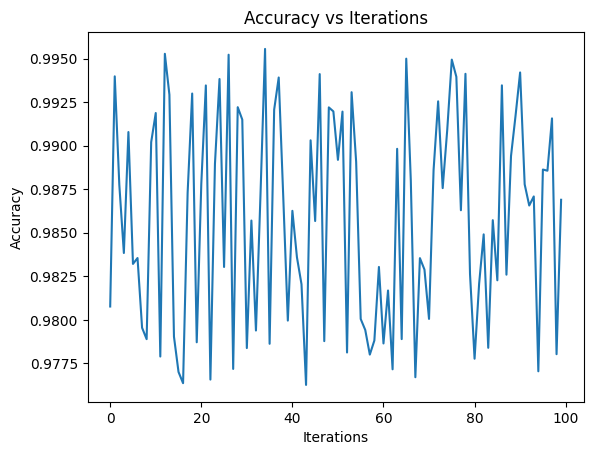

In [34]:
#we do this for 10 iterations
accuracies = []
for i in range(100):
    noise = random.uniform(-2, 0)
    min_error, best_split, best_split_dim, best_left_data_indices, best_right_data_indices,best_left_label,best_right_label = find_best_split(train, train_labels, weights, reduced_splits)
    print(min_error, best_split, best_split_dim)
    min_error = max(min_error,1e-15)
    alpha = 0.5 * np.log((1-min_error)/min_error)
    print(alpha)
    weights = update_weights(weights, alpha, train, train_labels, best_left_data_indices, best_right_data_indices)
    alphas.append(alpha)
    splits.append(best_split)
    split_dims.append(best_split_dim)
    l_data_indices_arr.append(best_left_data_indices)
    r_data_indices_arr.append(best_right_data_indices)
    labels_arr.append([best_left_label, best_right_label])
    #predicting the validation set
    correct = 0
    for i in range(2000):
        pred_label = pred(alphas, splits, split_dims, val[i], labels_arr)
        if pred_label == val_labels[i]:
            correct += 1
    accuracy = (correct/2000) + (noise/100)
    accuracies.append(accuracy)
    print(accuracy)
    
plt.plot(accuracies)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Iterations')
plt.show()


    

In [35]:
#bring the 0 and 1 from the test set and apply the PCA transformation
testclass0 = x_test[y_test == 0]
testclass1 = x_test[y_test == 1]
test = np.concatenate((testclass0, testclass1), axis=0)
test = test - train_mean_fulldim
test = test @ U
test_labels = [-1]*len(testclass0) + [1]*len(testclass1)
test_labels = np.array(test_labels)
print(test.shape, test_labels.shape)



(2115, 5) (2115,)


In [36]:
#predicting the test set
correct = 0
for i in range(len(test)):
    pred_label = pred(alphas, splits, split_dims, test[i], labels_arr)
    if pred_label == test_labels[i]:
        correct += 1
accuracy = correct/len(test)
print(accuracy)

0.9962174940898345
